<a href="https://colab.research.google.com/github/Duncan-Sembeguya/Duncan-Sembeguya/blob/main/Sales_And_RFM_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SALES ANALYSIS 
Sample Sales Data, Order Info, Sales, Customer, Shipping, etc., Used for Segmentation, Customer Analytics, Clustering and More. Inspired for retail analytics. This was originally used for Pentaho DI Kettle, But I found the set could be useful for Sales Simulation training.
Originally Written by María Carina Roldán, Pentaho Community Member, BI consultant (Assert Solutions), Argentina. This work is licensed under the Creative Commons Attribution-Noncommercial-Share Alike 3.0 Unported License. Modified by Gus Segura June 2014.


### DOWNLOAD the data from Kaggle.com

In [148]:
!pip install opendatasets --upgrade --quiet


In [149]:
import opendatasets as od

od.download('https://www.kaggle.com/kyanyoga/sample-sales-data')

Skipping, found downloaded files in "./sample-sales-data" (use force=True to force download)


In [150]:
df = './sample-sales-data/sales_data_sample.csv'

In [151]:
#import libraries
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
import gc
import time
import matplotlib.ticker as ticker
import plotly.express as px

#supress warnings
import warnings
warnings.filterwarnings("ignore")

Loading data

In [152]:
sales_data = pd.read_csv(df, encoding= 'unicode_escape')
sales_data
sales_data.head()


,ORDERNUMBER,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,STATUS,QTR_ID,MONTH_ID,YEAR_ID,PRODUCTLINE,MSRP,PRODUCTCODE,CUSTOMERNAME,PHONE,ADDRESSLINE1,ADDRESSLINE2,CITY,STATE,POSTALCODE,COUNTRY,TERRITORY,CONTACTLASTNAME,CONTACTFIRSTNAME,DEALSIZE
0,10107,30,95.70,2,2871.00,2/24/2003 0:00,Shipped,1,2,2003,Motorcycles,95,S10_1678,Land of Toys Inc.,2125557818,897 Long Airport Avenue,NaN,NYC,NY,10022,USA,NaN,Yu,Kwai,Small
1,10121,34,81.35,5,2765.90,5/7/2003 0:00,Shipped,2,5,2003,Motorcycles,95,S10_1678,Reims Collectables,26.47.1555,59 rue de l'Abbaye,NaN,Reims,NaN,51100,France,EMEA,Henriot,Paul,Small
2,10134,41,94.74,2,3884.34,7/1/2003 0:00,Shipped,3,7,2003,Motorcycles,95,S10_1678,Lyon Souveniers,+33 1 46 62 7555,27 rue du Colonel Pierre Avia,NaN,Paris,NaN,75508,France,EMEA,Da Cunha,Daniel,Medium
3,10145,45,83.26,6,3746.70,8/25/2003 0:00,Shipped,3,8,2003,Motorcycles,95,S10_1678,Toys4GrownUps.com,6265557265,78934 Hillside Dr.,NaN,Pasadena,CA,90003,USA,NaN,Young,Julie,Medium
4,10159,49,100.00,14,5205.27,10/10/2003 0:00,Shipped,4,10,2003,Motorcycles,95,S10_1678,Corporate Gift Ideas Co.,6505551386,7734 Strong St.,NaN,San Francisco,CA,NaN,USA,NaN,Brown,Julie,Medium


In [153]:
sales_data.columns

Index(['ORDERNUMBER', 'QUANTITYORDERED', 'PRICEEACH', 'ORDERLINENUMBER',
       'SALES', 'ORDERDATE', 'STATUS', 'QTR_ID', 'MONTH_ID', 'YEAR_ID',
       'PRODUCTLINE', 'MSRP', 'PRODUCTCODE', 'CUSTOMERNAME', 'PHONE',
       'ADDRESSLINE1', 'ADDRESSLINE2', 'CITY', 'STATE', 'POSTALCODE',
       'COUNTRY', 'TERRITORY', 'CONTACTLASTNAME', 'CONTACTFIRSTNAME',
       'DEALSIZE'],
      dtype='object')

## DATA CLEANING AND PREPARATION 
- Check and solve for missing values and errors
- Parse 'ORDERDATE' column to a workable pandas datetime format
- Setting the index to be 'ORDERDATE' column

In [154]:
## Missing values percentanges
missing_percentages = (sales_data.isna().sum().sort_values(ascending = False)/len(sales_data))*100
missing_percentages

ADDRESSLINE2        89.302161
STATE               52.639036
TERRITORY           38.044633
POSTALCODE           2.692171
DEALSIZE             0.000000
YEAR_ID              0.000000
QUANTITYORDERED      0.000000
PRICEEACH            0.000000
ORDERLINENUMBER      0.000000
SALES                0.000000
ORDERDATE            0.000000
STATUS               0.000000
QTR_ID               0.000000
MONTH_ID             0.000000
PRODUCTCODE          0.000000
PRODUCTLINE          0.000000
MSRP                 0.000000
CONTACTFIRSTNAME     0.000000
CUSTOMERNAME         0.000000
PHONE                0.000000
ADDRESSLINE1         0.000000
CITY                 0.000000
COUNTRY              0.000000
CONTACTLASTNAME      0.000000
ORDERNUMBER          0.000000
dtype: float64

In [155]:
## Dropping the irrelevant variables and those with NAs.
to_drop = ['PHONE','ADDRESSLINE1','ADDRESSLINE2','STATE','POSTALCODE']
sales_data = sales_data.drop(to_drop, axis=1)

COUNTRY and CITY will represent the order geographical information.

In [156]:
sales_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2823 entries, 0 to 2822
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ORDERNUMBER       2823 non-null   int64  
 1   QUANTITYORDERED   2823 non-null   int64  
 2   PRICEEACH         2823 non-null   float64
 3   ORDERLINENUMBER   2823 non-null   int64  
 4   SALES             2823 non-null   float64
 5   ORDERDATE         2823 non-null   object 
 6   STATUS            2823 non-null   object 
 7   QTR_ID            2823 non-null   int64  
 8   MONTH_ID          2823 non-null   int64  
 9   YEAR_ID           2823 non-null   int64  
 10  PRODUCTLINE       2823 non-null   object 
 11  MSRP              2823 non-null   int64  
 12  PRODUCTCODE       2823 non-null   object 
 13  CUSTOMERNAME      2823 non-null   object 
 14  CITY              2823 non-null   object 
 15  COUNTRY           2823 non-null   object 
 16  TERRITORY         1749 non-null   object 


In [157]:
### Changing the data type of variable 'ORDERDATE' from object to datetime
sales_data['ORDERDATE'] = pd.to_datetime(sales_data['ORDERDATE'])

Checking for errors

In [158]:
## A Summary Distribution of the Quantitative Variables
quantitative_variable = ['QUANTITYORDERED','PRICEEACH','SALES','MSRP']
sales_data[quantitative_variable].describe()

,QUANTITYORDERED,PRICEEACH,SALES,MSRP
count,2823.000000,2823.000000,2823.000000,2823.000000
mean,35.092809,83.658544,3553.889072,100.715551
std,9.741443,20.174277,1841.865106,40.187912
min,6.000000,26.880000,482.130000,33.000000
25%,27.000000,68.860000,2203.430000,68.000000
50%,35.000000,95.700000,3184.800000,99.000000
75%,43.000000,100.000000,4508.000000,124.000000
max,97.000000,100.000000,14082.800000,214.000000


There are no negative values for the quantitative variables, this is a good sign because we cannot have negative prices or quantities.

## DATA EXPLORATION 

PLOT DISTRIBUTION FOR ALL QUANTITATIVE VARIABLES

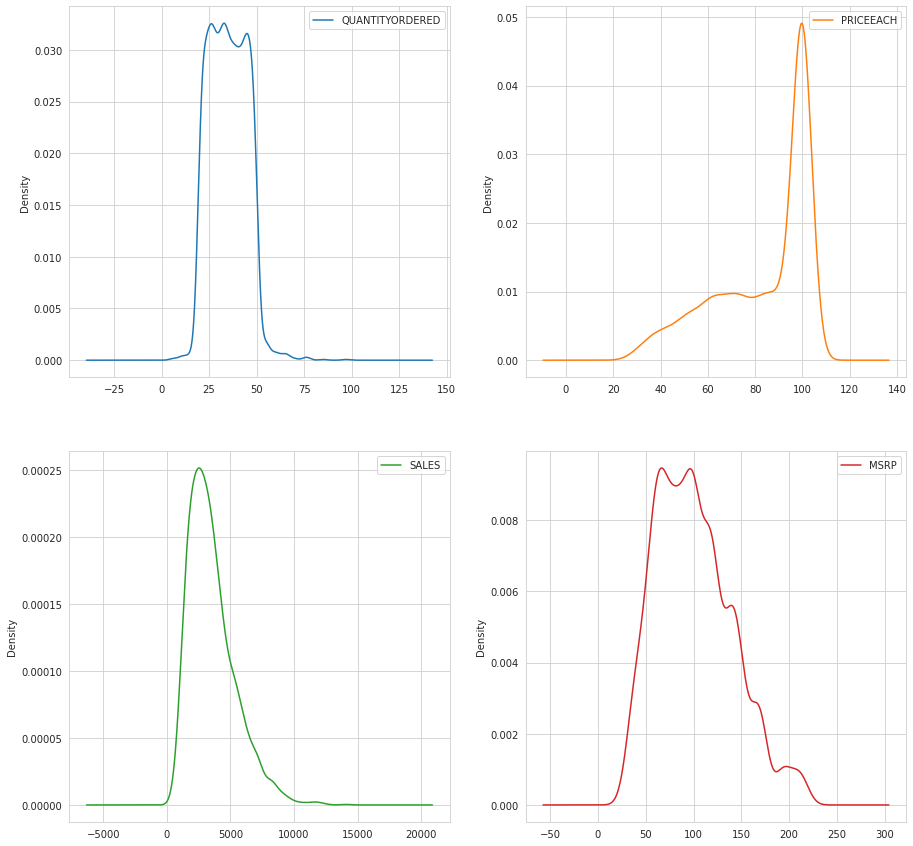

In [159]:
sales_data[quantitative_variable].plot(kind='density', subplots=True, sharex=False, sharey=False, layout=(2,2),figsize=(15,15))
plt.show()

 QUANTITYORDERED: we can see value between 30 to 50 has most order frequency.

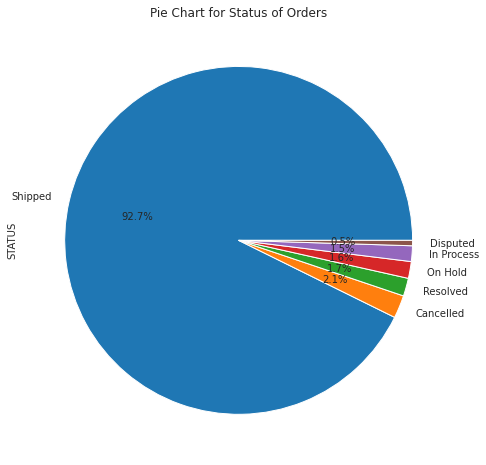

In [160]:
## Frequency distribution of status
status = sales_data['STATUS'].value_counts(normalize = True)
plt.figure(figsize=(16,8))
status.plot(kind= 'pie', autopct='%1.1f%%')
plt.title("Pie Chart for Status of Orders")
plt.show()

Majority of the orders (93%) have already been shipped.

Checking for time frame of the data

In [161]:
sales_data.groupby(['YEAR_ID'])['MONTH_ID'].nunique()

YEAR_ID
2003    12
2004    12
2005     5
Name: MONTH_ID, dtype: int64

2005 has incomplete data, monthly data will be used for further analysis

#### MONTHLY REVENUES 

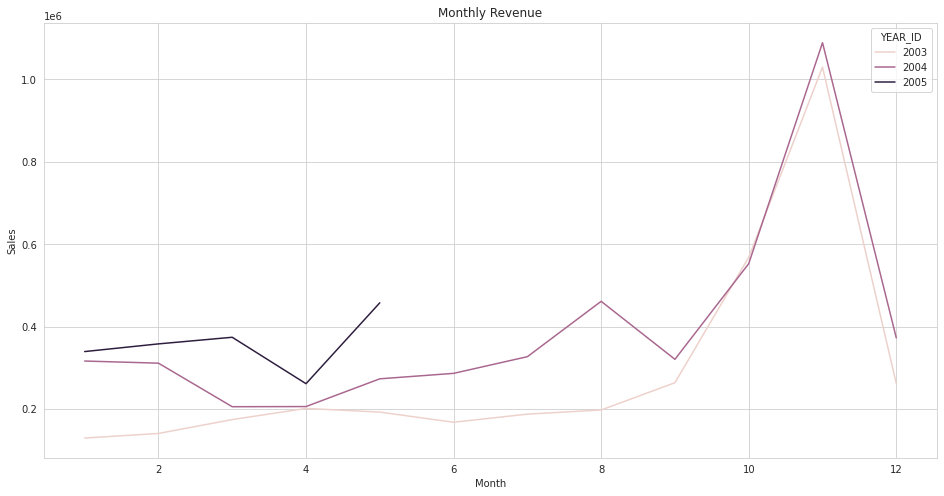

In [162]:
#Monthly Revenue
plt.figure(figsize=(16,8))

monthly_revenue = sales_data.groupby(['YEAR_ID','MONTH_ID'])['SALES'].sum().reset_index()
sns.lineplot(x="MONTH_ID", y="SALES",hue="YEAR_ID", data = monthly_revenue)
plt.xlabel('Month')
plt.ylabel('Sales')
plt.title('Monthly Revenue')
plt.show()

The data shows that for both  2003 and 2004 sales peaked around October and November, this might be due to the many festivities and holidays around that time(Thanksgiving, Halloween, National Days, et al). 

We dont have enough data for 2005 but the available data shows the sales had increased compared to previous months in 2003 and 2004

[]

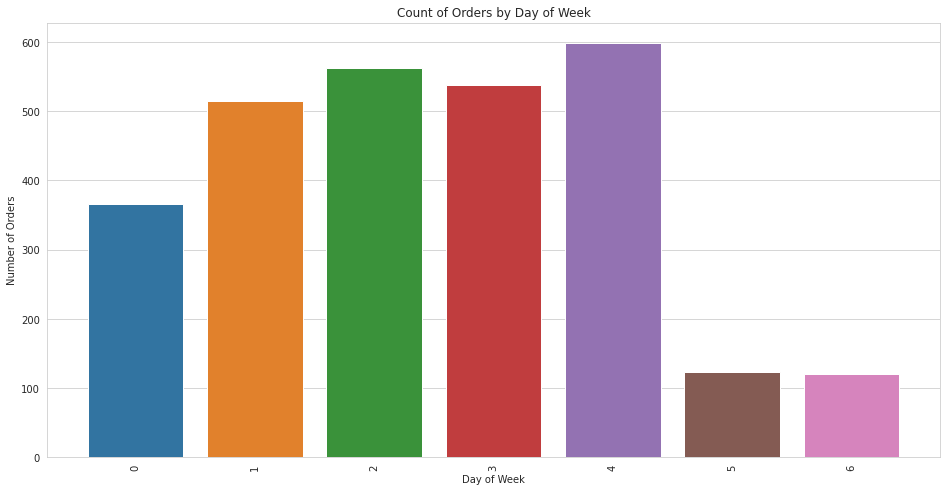

In [163]:
## Get the hour for each sale timestamp
sales_data['ORDERDATE'].dt.dayofweek
plt.figure(figsize=(16,8))
sns.countplot(sales_data['ORDERDATE'].dt.dayofweek)
plt.title('Count of Orders by Day of Week')
plt.xticks(np.arange(0,7),np.arange(0,7),rotation=90)
plt.xlabel('Day of Week')
plt.ylabel('Number of Orders')
plt.plot()


Most sales happen on Friday, closely followed by Wednesday. So if the retailer is going to advertise effectively to increase the likelihood of more sales, they should advertise more on between Tuesday and Friday when they have more customer traffic.

#### COUNTRY SALES

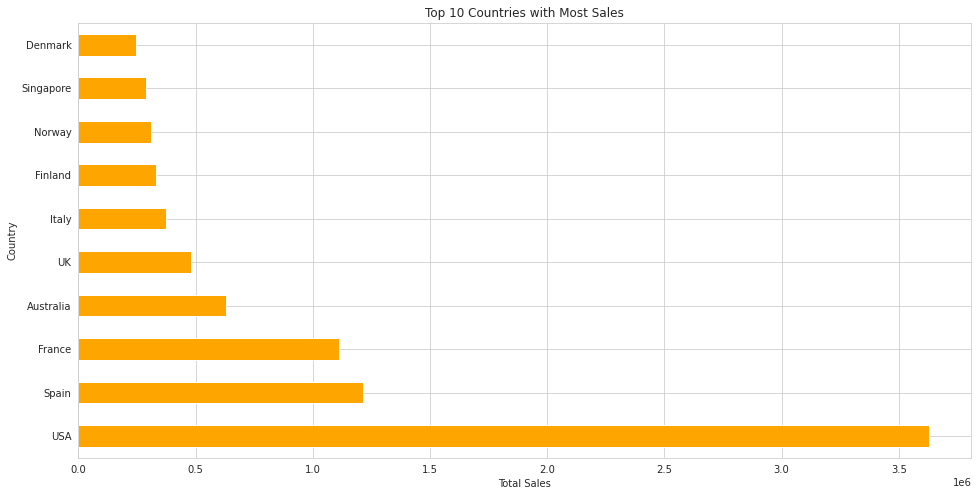

In [164]:
plt.figure(figsize=(16,8))
sales_per_country = sales_data.groupby(['COUNTRY'])['SALES'].sum().sort_values(ascending=False)
sales_per_country[:10].plot(kind = 'barh', color='orange')
plt.title('Top 10 Countries with Most Sales')
plt.xlabel('Total Sales')
plt.ylabel('Country')
plt.show()

USA has the most sales, followed by Spain and France

#### CITY SALES

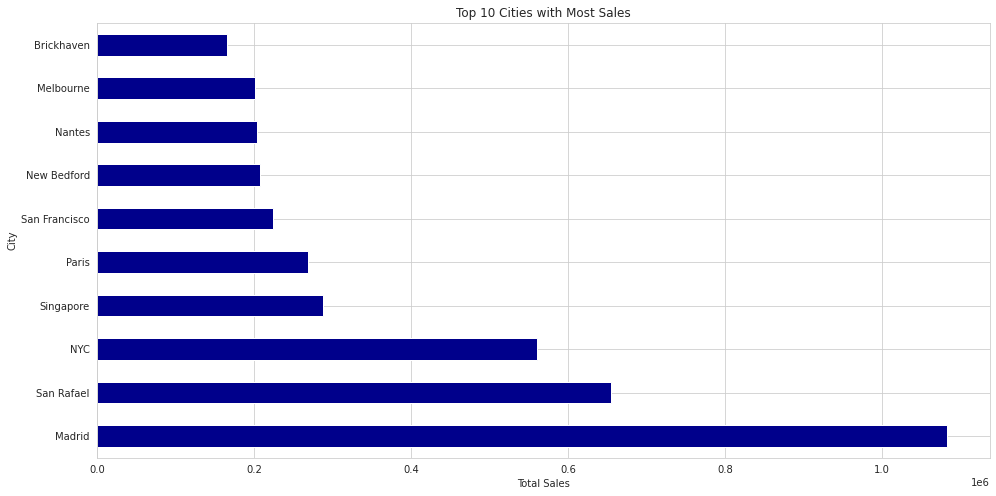

In [165]:
plt.figure(figsize=(16,8))
sales_per_city = sales_data.groupby(['CITY'])['SALES'].sum().sort_values(ascending=False)
sales_per_city[:10].plot(kind = 'barh', color='darkblue')
plt.title('Top 10 Cities with Most Sales')
plt.xlabel('Total Sales')
plt.ylabel('City')
plt.show()

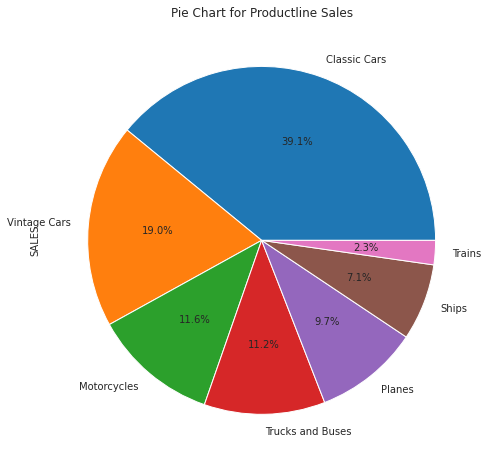

In [166]:

product_sales = (sales_data.groupby(['PRODUCTLINE'])['SALES'].sum().sort_values(ascending=False)/sales_data['SALES'].sum())*100
plt.figure(figsize=(16,8))
product_sales.plot(kind= 'pie', autopct='%1.1f%%')
plt.title("Pie Chart for Productline Sales")
plt.show()

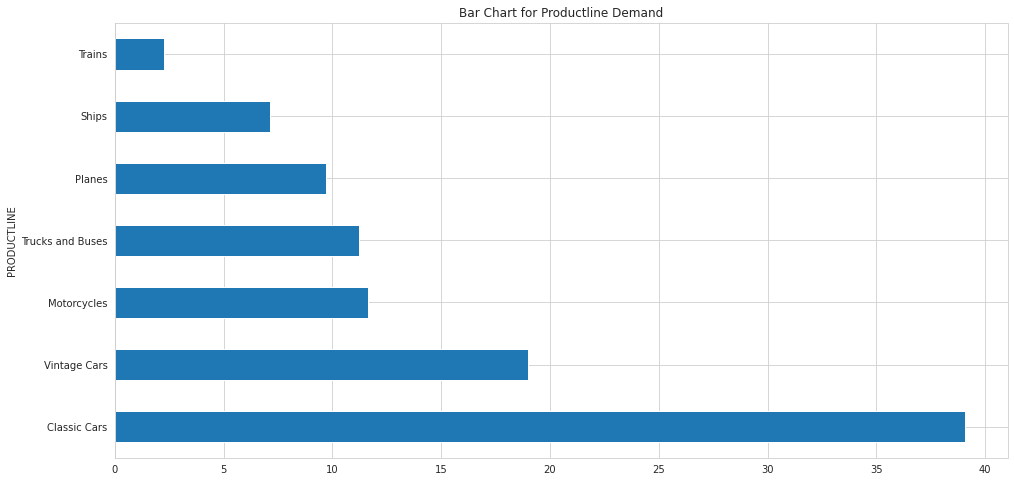

In [167]:
product_demand = sales_data.groupby(['PRODUCTLINE'])['QUANTITYORDERED'].sum().sort_values(ascending=False)
plt.figure(figsize=(16,8))
product_sales.plot(kind= 'barh')
plt.title("Bar Chart for Productline Demand")
plt.show()

Classic cars are sold the most with over 30000 units sold at 39.1% followed by vintage cars and motorcycles.

#### Testing for Relationships within variables

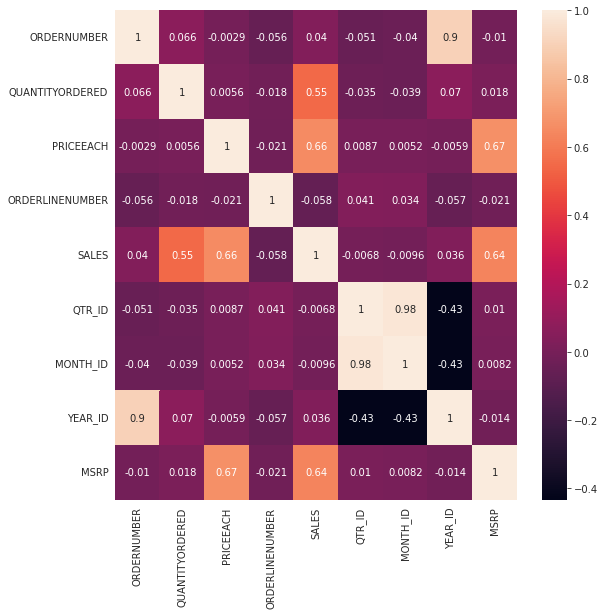

In [168]:
plt.figure(figsize = (9,9))
corr_matrix = sales_data.corr()
sns.heatmap(corr_matrix, annot = True)

###### Relevant observations
There is a positively correlated between SALES, QUANTITYORDERED, PRICEEACH and MSRP. This means The higher the price of product the more orders it recieves and the quantities ordered the more the sales generated

## RFM analysis (recency, frequency, monetary):

RFM analysis is a marketing technique used to quantitatively rank and group customers based on the recency, frequency and monetary total of their recent transactions to identify the best customers and perform targeted marketing campaigns.

- For RFM analysis, we need only these columns. 'CUSTOMERNAME', 'ORDERNUMBER', 'ORDERDATE' and 'SALES'

In [169]:
rfm = ['CUSTOMERNAME', 'ORDERNUMBER', 'ORDERDATE', 'SALES']
rfm_data = sales_data[rfm]
rfm_data.head()

,CUSTOMERNAME,ORDERNUMBER,ORDERDATE,SALES
0,Land of Toys Inc.,10107,2003-02-24,2871.00
1,Reims Collectables,10121,2003-05-07,2765.90
2,Lyon Souveniers,10134,2003-07-01,3884.34
3,Toys4GrownUps.com,10145,2003-08-25,3746.70
4,Corporate Gift Ideas Co.,10159,2003-10-10,5205.27


##### Create the RFM Table

We will use to calculate recency, frequency and monetary value
 - Recency = most recent date - last order date of customer
 - Frequency = Number of orders per customer
 - Sales = Sales per Customer


In [170]:
NOW = rfm_data['ORDERDATE'].max()  # Most recent date
RFM_table=rfm_data.groupby('CUSTOMERNAME').agg({'ORDERDATE': lambda x: (NOW - x.max()).days, # Recency
                                                'ORDERNUMBER': 'count', # Frequency
                                                'SALES': 'sum'})    # Monetary 

RFM_table['ORDERDATE'] = RFM_table['ORDERDATE'].astype(int)

RFM_table.rename(columns={'ORDERDATE': 'Recency', 
                         'ORDERNUMBER': 'Frequency',
                         'SALES': 'Monetary_value'}, inplace=True)
RFM_table.head()

,Recency,Frequency,Monetary_value
CUSTOMERNAME,,,
"AV Stores, Co.",195,51,157807.81
Alpha Cognac,64,20,70488.44
Amica Models & Co.,264,26,94117.26
"Anna's Decorations, Ltd",83,46,153996.13
Atelier graphique,187,7,24179.96


### CUSTOMER SEGMENTATION

Dividing the customer into 4 segments(Randomly Chosen)

Recency/Frequency/MonetaryValue : Level 4 > Level 3> Level 2 > Level 1

Lower the recency, higher the Recency level
Higher the number of orders, higher the Frequency level
Higher the monetary value, higher the MonetaryValue level

In [171]:
#Dividing into segments

# Create a spend quartile with 4 groups - a range between 1 and 5
Recency_quartile = pd.qcut(RFM_table['Recency'], q=4, labels=list(range(4, 0, -1)))
Frequency_quartile = pd.qcut(RFM_table['Frequency'], q=4, labels=range(1,5))
MonetaryValue_quartile = pd.qcut(RFM_table['Monetary_value'], q=4, labels=range(1,5))


# Assign the quartile values to the Spend_Quartile column in data
RFM_table['r_quartile'] = Recency_quartile
RFM_table['f_quartile'] = Frequency_quartile
RFM_table['m_quartile'] = MonetaryValue_quartile

RFM_table.head()

,Recency,Frequency,Monetary_value,r_quartile,f_quartile,m_quartile
CUSTOMERNAME,,,,,,
"AV Stores, Co.",195,51,157807.81,2,4,4
Alpha Cognac,64,20,70488.44,4,2,2
Amica Models & Co.,264,26,94117.26,1,2,3
"Anna's Decorations, Ltd",83,46,153996.13,3,4,4
Atelier graphique,187,7,24179.96,2,1,1


#### Calculating RFM Score

In [172]:
RFM_table['RFM_Score'] = RFM_table[['r_quartile','f_quartile','m_quartile']].sum(axis=1)
RFM_table.head()

,Recency,Frequency,Monetary_value,r_quartile,f_quartile,m_quartile,RFM_Score
CUSTOMERNAME,,,,,,,
"AV Stores, Co.",195,51,157807.81,2,4,4,10
Alpha Cognac,64,20,70488.44,4,2,2,8
Amica Models & Co.,264,26,94117.26,1,2,3,6
"Anna's Decorations, Ltd",83,46,153996.13,3,4,4,11
Atelier graphique,187,7,24179.96,2,1,1,4


In [173]:
#Assigning Value to Customers

def rfm_value(df):
    if np.bool(df['RFM_Score'] >= 10):
        return 'High Value Customer'
    elif np.bool((df['RFM_Score'] < 10) & (df['RFM_Score'] >= 6)):
        return 'Mid Value Customer'
    else:
        return 'Low Value Customer'

RFM_table['RFM_Value'] = RFM_table.apply(rfm_value, axis=1)

RFM_table.head()

,Recency,Frequency,Monetary_value,r_quartile,f_quartile,m_quartile,RFM_Score,RFM_Value
CUSTOMERNAME,,,,,,,,
"AV Stores, Co.",195,51,157807.81,2,4,4,10,High Value Customer
Alpha Cognac,64,20,70488.44,4,2,2,8,Mid Value Customer
Amica Models & Co.,264,26,94117.26,1,2,3,6,Mid Value Customer
"Anna's Decorations, Ltd",83,46,153996.13,3,4,4,11,High Value Customer
Atelier graphique,187,7,24179.96,2,1,1,4,Low Value Customer


The RFM Score sums up Recency, Frequency, Monetary Value;
 - Customers with RFM_Score >= 10 are high value customers
 - Low value customers are those with RFM_Score <= 5, the rest are mid-value customers.

<function matplotlib.pyplot.show>

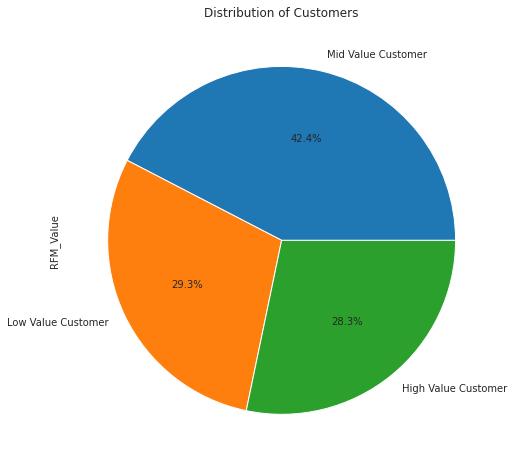

In [174]:
## Frequency distribution of Customers
customer_value = RFM_table['RFM_Value'].value_counts(normalize = True)
plt.figure(figsize=(16,8))
customer_value.plot(kind= 'pie', autopct='%1.1f%%')
plt.title("Distribution of Customers")
plt.show

Majority of customers are mid-value customers with low-value and high-value customers being more or less the same.

RFM segmentation readily answers these questions for your business…

 - Who are my best customers(Whales)?
 - Who are the Lapsed customers (Customers with low recency but high Monetary value)?
 - Who are your loyal customers?
 - Which customers you must retain?
 - Who has the potential to be converted in more profitable customers?
 - New customers (Customers with high recency and low frequency)?
 - Which group of customers is most likely to respond to your current campaign?

Best customers (Whales)

- The biggest customers with high (4,4,4) values in all three factors that should be targeted with special promotions to keep them active.


In [175]:
#Who are my best customers? (Whales)
RFM_table[RFM_table['RFM_Score']==12].sort_values('Monetary_value', ascending=False)

,Recency,Frequency,Monetary_value,r_quartile,f_quartile,m_quartile,RFM_Score,RFM_Value
CUSTOMERNAME,,,,,,,,
Euro Shopping Channel,0,259,912294.11,4,4,4,12,High Value Customer
Mini Gifts Distributors Ltd.,2,180,654858.06,4,4,4,12,High Value Customer
La Rochelle Gifts,0,53,180124.90,4,4,4,12,High Value Customer
The Sharp Gifts Warehouse,39,40,160010.27,4,4,4,12,High Value Customer
Souveniers And Things Co.,2,46,151570.98,4,4,4,12,High Value Customer
Salzburg Collectables,14,40,149798.63,4,4,4,12,High Value Customer
Danish Wholesale Imports,46,36,145041.60,4,4,4,12,High Value Customer
L'ordine Souveniers,21,39,142601.33,4,4,4,12,High Value Customer
Reims Collectables,62,41,135042.94,4,4,4,12,High Value Customer


Lapsed customers. 

- Customers with low recency but high value (1,X,5) were once valuable customers but have since stopped. A targeted message may reactivate them.


In [176]:
RFM_table[RFM_table['r_quartile'] >= 2 ].sort_values('m_quartile', ascending=False).head(10)

,Recency,Frequency,Monetary_value,r_quartile,f_quartile,m_quartile,RFM_Score,RFM_Value
CUSTOMERNAME,,,,,,,,
"AV Stores, Co.",195,51,157807.81,2,4,4,10,High Value Customer
"Corrida Auto Replicas, Ltd",211,32,120615.28,2,3,4,9,Mid Value Customer
"Saveley & Henriot, Co.",455,41,142874.25,1,4,4,9,Mid Value Customer
Rovelli Gifts,200,48,137955.72,2,4,4,10,High Value Customer
Online Diecast Creations Co.,208,34,131685.30,2,4,4,10,High Value Customer
Land of Toys Inc.,197,49,164069.44,2,4,4,10,High Value Customer
Vitachrome Inc.,207,25,88041.26,2,2,3,7,Mid Value Customer
"Vida Sport, Ltd",274,31,117713.56,1,3,3,7,Mid Value Customer
"Toms Spezialitten, Ltd",227,26,100306.58,2,2,3,7,Mid Value Customer


##### Lost customers
- Customers who's recency, frequency as well as monetary values are low 

In [177]:
RFM_table[RFM_table['RFM_Score']==3].sort_values('Monetary_value', ascending=False)

,Recency,Frequency,Monetary_value,r_quartile,f_quartile,m_quartile,RFM_Score,RFM_Value
CUSTOMERNAME,,,,,,,,
Auto Assoc. & Cie.,232,18,64834.32,1,1,1,3,Low Value Customer
"Clover Collections, Co.",257,16,57756.43,1,1,1,3,Low Value Customer
Online Mini Collectables,263,15,57197.96,1,1,1,3,Low Value Customer
"Iberia Gift Imports, Corp.",237,15,54723.62,1,1,1,3,Low Value Customer
Signal Collectibles Ltd.,476,15,50218.51,1,1,1,3,Low Value Customer
CAF Imports,438,13,49642.05,1,1,1,3,Low Value Customer
"Men 'R' US Retailers, Ltd.",508,14,48048.46,1,1,1,3,Low Value Customer
West Coast Collectables Co.,488,13,46084.64,1,1,1,3,Low Value Customer
Cambridge Collectables Co.,388,11,36163.62,1,1,1,3,Low Value Customer


Most loyal customers
- Customers with high frequency value (Returning Customers)

In [178]:
RFM_table[RFM_table['f_quartile'] == 4 ].sort_values('Monetary_value', ascending=False)

,Recency,Frequency,Monetary_value,r_quartile,f_quartile,m_quartile,RFM_Score,RFM_Value
CUSTOMERNAME,,,,,,,,
Euro Shopping Channel,0,259,912294.11,4,4,4,12,High Value Customer
Mini Gifts Distributors Ltd.,2,180,654858.06,4,4,4,12,High Value Customer
"Australian Collectors, Co.",183,55,200995.41,3,4,4,11,High Value Customer
Muscle Machine Inc,181,48,197736.94,3,4,4,11,High Value Customer
La Rochelle Gifts,0,53,180124.90,4,4,4,12,High Value Customer
"Dragon Souveniers, Ltd.",90,43,172989.68,3,4,4,11,High Value Customer
Land of Toys Inc.,197,49,164069.44,2,4,4,10,High Value Customer
The Sharp Gifts Warehouse,39,40,160010.27,4,4,4,12,High Value Customer
"AV Stores, Co.",195,51,157807.81,2,4,4,10,High Value Customer
